# **Time Series**
Disini saya akan ambil data geospasial dari Copernicus Data Space (via OpenEO API) dan lanjutkan analisisnya di Python (sampai ke tahap KNN Regression).
## **1. Mengambil data dari Copernicus Data Space (OpenEO)**
Sebelum itu pastikan untuk menginstal pustaka:

In [7]:
pip install openeo geopandas pandas scikit-learn rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 96.3 MB/s eta 0:00:00


Lanjut ke python script:

In [5]:
import openeo
import geopandas as gpd

# 1️⃣ Hubungkan ke backend Copernicus
conn = openeo.connect("https://openeo.dataspace.copernicus.eu/openeo/1.2")

# (opsional) login kalau mau data tertentu
conn.authenticate_oidc()  # akan membuka browser untuk login Copernicus

# 2️⃣ Definisikan area (GeoJSON)
area = gpd.read_file("map.geojson")
bbox = area.total_bounds  # [minx, miny, maxx, maxy]

# 3️⃣ Pilih koleksi data (misalnya Sentinel-2)
cube = conn.load_collection(
    "SENTINEL2_L2A",
    spatial_extent={"west": bbox[0], "south": bbox[1], "east": bbox[2], "north": bbox[3]},
    temporal_extent=["2025-01-01", "2025-10-01"],
    bands=["B04", "B08"]  # Red & NIR band
)

# 4️⃣ Hitung NDVI
ndvi = (cube.band("B08") - cube.band("B04")) / (cube.band("B08") + cube.band("B04"))

# 5️⃣ Agregasi waktu (misalnya mean bulanan)
ndvi_mean = ndvi.aggregate_temporal_period(period="month", reducer="mean")

# 6️⃣ Download hasil ke GeoTIFF/CSV
ndvi_mean.download("ndvi_mean.tiff", format="GTiff")


Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=WNWQ-TQZS 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


## **2. Mengonversi hasil ke CSV / GeoJSON**
Setelah file ndvi_mean.tiff berhasil diunduh:

In [8]:
import rasterio
import pandas as pd
import numpy as np

with rasterio.open("ndvi_mean.tiff") as src:
    data = src.read(1)
    transform = src.transform

rows, cols = np.where(~np.isnan(data))
xs, ys = rasterio.transform.xy(transform, rows, cols)
values = data[rows, cols]

df = pd.DataFrame({"x": xs, "y": ys, "ndvi": values})
df.to_csv("ndvi_data.csv", index=False)


## **3. Tangani Missing Values**

In [9]:
df = df.interpolate(method="linear").dropna()


## **4. Bentuk Data Supervised**
Pada tahap ini gunakan nilai NDVI sebelumnya untuk memprediksi nilai sekarang:

In [10]:
def make_supervised(df, target, n_lags):
    for i in range(1, n_lags+1):
        df[f"{target}_lag{i}"] = df[target].shift(i)
    df = df.dropna()
    return df

df_sup = make_supervised(df, target="ndvi", n_lags=3)


## **5. Normalisasi**

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_sup)
df_scaled = pd.DataFrame(scaled, columns=df_sup.columns)


## **6. KNN Regression**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_scaled.drop("ndvi", axis=1)
y = df_scaled["ndvi"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 0.000919768356933611
R²: 0.8690348457611776


## **Visualisasi Hasil**

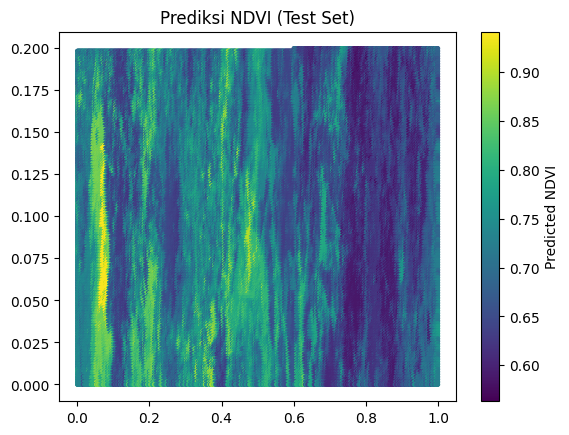

In [14]:
plt.scatter(X_test["x"], X_test["y"], c=y_pred, cmap="viridis", s=5)
plt.colorbar(label="Predicted NDVI")
plt.title("Prediksi NDVI (Test Set)")
plt.show()
